# Experimental Results and Analysis

This notebook contains the code necessary to reproduce the experiments presented in *Section 4*.

In [1]:
import pandas as pd
from scipy.spatial.distance import cdist
from umap.umap_ import UMAP
from models import VAE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import torch
torch.manual_seed(1610)

In [2]:
data = pd.read_csv('data/training_dataset.csv')
print(data.shape)
data.dropna(inplace=True)
print(data.shape)
data.head()

(4541, 106)
(4541, 106)


,Player,Nation,Pos_fbref,Squad,League,Age,Born,90s,Standard_Sh/90,Standard_SoT/90,...,Performance_Crs/90,Performance_Int/90,Aerial_Duels_Won/90,Aerial_Duels_Lost/90,Pos_tm,Height,RightFoot,MarketValue,LeagueRank,SquadRank
0,Max Aarons,eng ENG,DF,Bournemouth,Premier League,23.0,2000.0,13.7,0.15,0.00,...,0.948905,0.583942,0.364964,0.802920,Right-Back,177,1,€16.00m,1772.01394,1711.891602
1,Tosin Adarabioyo,eng ENG,DF,Fulham,Premier League,25.0,1997.0,18.0,0.78,0.28,...,0.055556,1.388889,3.111111,1.555556,Centre-Back,197,1,€20.00m,1772.01394,1717.380493
2,Simon Adingra,ci CIV,FW,Brighton,Premier League,21.0,2002.0,24.7,2.11,0.89,...,3.076923,0.769231,0.323887,0.485830,Left Winger,175,1,€30.00m,1772.01394,1820.636597
3,Nayef Aguerd,ma MAR,DF,West Ham,Premier League,27.0,1996.0,20.6,0.68,0.15,...,0.242718,0.825243,2.330097,1.553398,Centre-Back,190,0,€35.00m,1772.01394,1808.972168
4,Anel Ahmedhodžić,ba BIH,DF,Sheffield Utd,Premier League,24.0,1999.0,29.4,0.65,0.17,...,0.204082,1.156463,1.768707,1.224490,Centre-Back,190,1,€18.00m,1772.01394,1580.956055


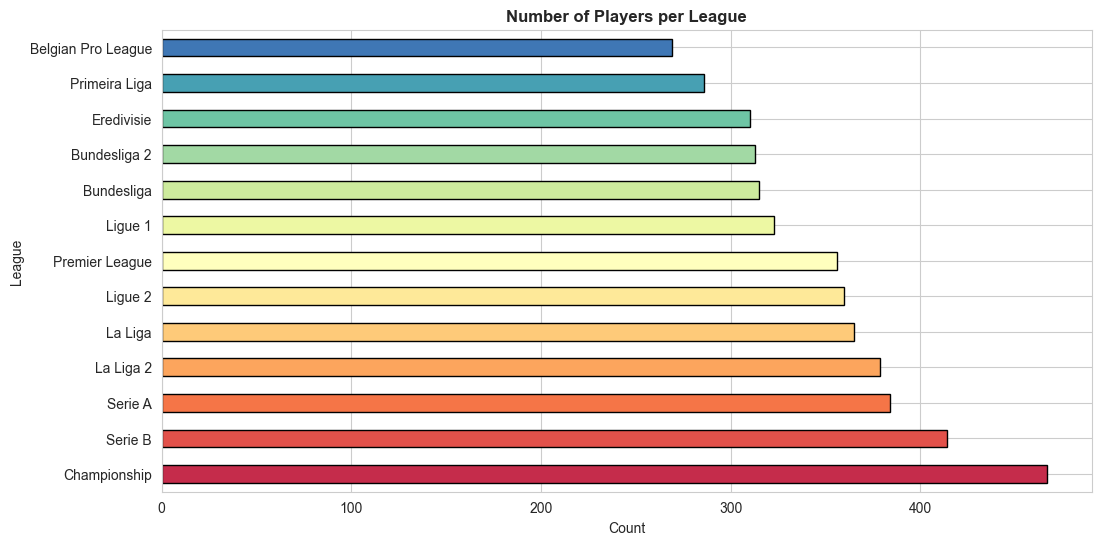

In [3]:
sns.set_style("whitegrid")

# Get league counts
league_counts = data['League'].value_counts()

# Plot
league_counts.plot(kind='barh', figsize=(12, 6),
                   color=sns.color_palette("Spectral", len(league_counts)),edgecolor='black')

# Title and labels
plt.title('Number of Players per League', fontsize=12, fontweight='bold')
plt.xlabel('Count', fontsize=10)
plt.ylabel('League', fontsize=10)

# Show the plot
plt.show()
# save
#plt.savefig('fig.png',dpi=200)


---


# Experiment 1: Latent Space visualization

In [4]:
position_order = ['Centre-Back', 'Right-Back', 'Left-Back', 'Defensive Midfield','Central Midfield', 'Attacking Midfield', 'Right Midfield', 'Left Midfield', 'Left Winger', 'Right Winger', 'Second Striker', 'Centre-Forward']  # Adjust as needed
data['Pos_tm'] = pd.Categorical(data['Pos_tm'], categories=position_order, ordered=True)
data.sort_values('Pos_tm',inplace=True)
data.reset_index(drop=True,inplace=True)

In [5]:
# change central midfield to midfield
data['Pos_tm'] = data['Pos_tm'].apply(lambda x : 'Midfield' if x in ['Central Midfield','Attacking Midfield','Left Midfield','Right Midfield'] else x)
data['Pos_tm'] = data['Pos_tm'].apply(lambda x : 'Winger' if x in ['Left Winger','Right Winger'] else x)
data['Pos_tm'] = data['Pos_tm'].apply(lambda x : 'Full-Back' if x in ['Left-Back','Right-Back'] else x)
data['Pos_tm'] = data['Pos_tm'].apply(lambda x : 'Striker' if x in ['Second Striker','Centre-Forward'] else x)

In [6]:
input_dim = 97
hidden_dim1 = 64
hidden_dim2 = 32
latent_dim = 16 
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
vae = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim1=hidden_dim1,hidden_dim2=hidden_dim2).to(device)
vae.load_state_dict(torch.load('checkpoints/vae.pth'))

<All keys matched successfully>

In [7]:
X = data.drop(['Player', 'Nation', 'Pos_fbref','Pos_tm', 'Squad','League', 'Born','90s','MarketValue'], axis=1).to_numpy(dtype='float32')
# Normalize data
X = torch.tensor(X, dtype=torch.float32)
print(X.shape)
X = (X -X.mean(dim=0)) / X.std(dim=0)

torch.Size([4541, 97])


In [8]:
players_embedding = vae(X.to(device))[1].detach().cpu().numpy() # [1] since we use the mean as the embedding

In [9]:
umap = UMAP(n_components=3,n_neighbors=10,metric='euclidean')
X_embedded_umap = umap.fit_transform(players_embedding)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
positions_colors = {
    'Centre-Back': 'navy',         # Medium Blue
    'Full-Back': 'cyan',          # Light Blue

    'Defensive Midfield': 'darkgreen',   #  Dark Green
    'Midfield': 'lightgreen', 

    'Winger': 'yellow', 
    
    'Striker': '#d62728'       # Red
}

In [11]:
color = data['Pos_tm'].map(positions_colors)

fig = px.scatter_3d(
    x=X_embedded_umap[:, 0],
    y=X_embedded_umap[:, 1],
    z=X_embedded_umap[:, 2],
    color=data['Pos_tm'],  # Group by 'Pos'
    color_discrete_map=positions_colors,#{'FW': 'red', 'MF': 'blue', 'DF': 'green'},
    labels={'x': 'X1', 'y': 'X2', 'z': 'X3'}
    )

fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
    ),
    width=800,
    height=550,
    # ticks fontsize
    font=dict(size=10),
    
)

fig.update_traces(marker=dict(size=1.8, line=dict(color='black', width=1)))

# # Increase legend marker size
fig.update_layout(
    legend=dict(
        title='Player Position',              # No title
        itemsizing='constant',  # Ensures constant size in legend
        font=dict(size=10),     # Adjust legend font size if needed
        itemwidth=30,            # Adjust spacing between legend items
    )
)

fig.show()

In [12]:
custom_palette = [
    "#052270",#"#1F77B4",  # Blue
    '#45C8C0',#"#FF7F0E",  # Orange
    '#244E0E',#"#2CA02C",  # Green
    '#7BB45D',#"#D62728",  # Red
    "#D6B10A",  # Purple
    "#F35C3E",  # Brown
    "#E377C2",  # Pink
    "#7F7F7F",  # Gray
    "#BCBD22",  # Yellow-Green
    "#17BECF",  # Cyan
    "#F4A261",  # Soft Orange
    "#264653",  # Dark Teal
    "#E63946",  # Bright Red
    "#A8DADC",  # Pale Cyan
    "#457B9D"   # Steel Blue
]
#fig, ax = plt.subplots(1,2,figsize=(24, 6))
# sns.kdeplot(x=players_embedding[:,3], hue=data['Pos_tm'], palette=custom_palette[:6],fill=True,ax=ax[0],alpha=0.25) #palette=positions_colors.values()
# ax[0].set_title('13th component distribution across Player position');
# sns.kdeplot(x=players_embedding[:,12], hue=data['League'], palette=custom_palette[:13],fill=True,ax=ax[1],alpha=0.25)
# ax[1].set_title('1th component distribution across League');

<Axes: ylabel='Density'>

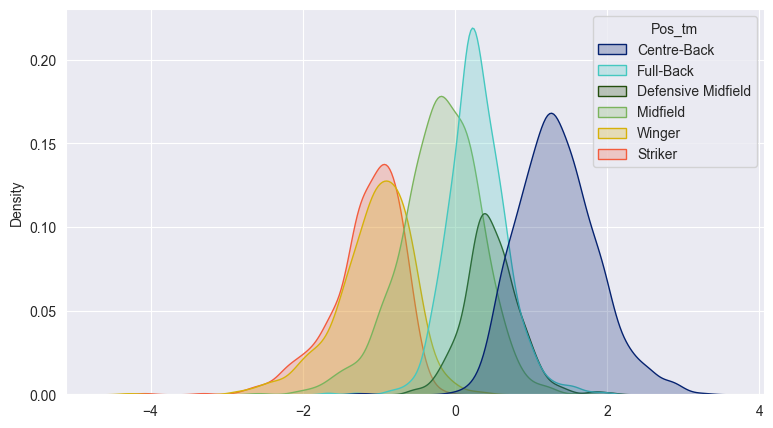

In [13]:
plt.figure(figsize=(9, 5))
sns.set_style("darkgrid")
sns.kdeplot(x=players_embedding[:,3], hue=data['Pos_tm'], palette=custom_palette[:6],fill=True,alpha=0.25)
#plt.tight_layout()
#plt.savefig('fig.png',dpi=200)

# Experiment 2: Scouting application

In [14]:
euclidean_mat = cdist(players_embedding, players_embedding, 'euclidean')

In [15]:
def print_top_k_similar_players(player,data=data,euclidean_mat=None,k=5):
    if euclidean_mat is None:
        raise ValueError('euclidean_mat is required')
            
    target_player_idx = data[data['Player']==player].index[0]
    nearest_players_distance   = euclidean_mat[target_player_idx,:].argsort()
    print(f"Top {k} players similar to {player}")
    display(data.loc[nearest_players_distance[0:k+1],['Player','Pos_tm','Age','Height','RightFoot','Squad','League']])


In [16]:
print_top_k_similar_players(player = 'Rafael Leão',euclidean_mat=euclidean_mat, k=5)
print_top_k_similar_players(player = 'Jamal Musiala',euclidean_mat=euclidean_mat, k=5)
print_top_k_similar_players(player = 'Olivier Giroud',euclidean_mat=euclidean_mat, k=5)
print_top_k_similar_players(player = 'Francesco Acerbi',euclidean_mat=euclidean_mat, k=5)

Top 5 players similar to Rafael Leão


,Player,Pos_tm,Age,Height,RightFoot,Squad,League
3510,Rafael Leão,Winger,24.0,188,1,Milan,Serie A
3416,Nico Williams,Winger,21.0,181,1,Athletic Club,La Liga
3728,Marcus Edwards,Winger,24.0,168,0,Sporting CP,Primeira Liga
3729,David Neres,Winger,26.0,176,0,Benfica,Primeira Liga
3711,Edon Zhegrova,Winger,24.0,180,0,Lille,Ligue 1
3715,Mason Greenwood,Winger,21.0,181,0,Getafe,La Liga


Top 5 players similar to Jamal Musiala


,Player,Pos_tm,Age,Height,RightFoot,Squad,League
3130,Jamal Musiala,Midfield,20.0,184,1,Bayern Munich,Bundesliga
3520,Bradley Barcola,Winger,20.0,182,1,Paris S-G,Ligue 1
3705,Brahim Díaz,Winger,23.0,170,0,Real Madrid,La Liga
3516,Amine Adli,Winger,23.0,174,0,Leverkusen,Bundesliga
3568,Lamine Yamal,Winger,16.0,180,0,Barcelona,La Liga
3498,Ibrahim Salah,Winger,21.0,186,1,Rennes,Ligue 1


Top 5 players similar to Olivier Giroud


,Player,Pos_tm,Age,Height,RightFoot,Squad,League
4094,Olivier Giroud,Striker,36.0,192,0,Milan,Serie A
4225,Niclas Füllkrug,Striker,30.0,189,1,Dortmund,Bundesliga
4284,Haris Tabakovic,Striker,29.0,194,1,Hertha BSC,Bundesliga 2
4173,Jonas Wind,Striker,24.0,190,1,Wolfsburg,Bundesliga
4123,Che Adams,Striker,27.0,179,1,Southampton,Championship
4040,Marko Arnautović,Striker,34.0,190,0,Inter,Serie A


Top 5 players similar to Francesco Acerbi


,Player,Pos_tm,Age,Height,RightFoot,Squad,League
113,Francesco Acerbi,Centre-Back,35.0,192,0,Inter,Serie A
268,Nicolò Casale,Centre-Back,25.0,191,1,Lazio,Serie A
97,Antonio Rüdiger,Centre-Back,30.0,190,1,Real Madrid,La Liga
863,Lukas Klostermann,Centre-Back,27.0,189,1,RB Leipzig,Bundesliga
543,Hauke Wahl,Centre-Back,29.0,189,1,St. Pauli,Bundesliga 2
484,Gianluca Mancini,Centre-Back,27.0,190,1,Roma,Serie A


**NOTE**: the same approach can be followed after filtering the dataset according to specific scouting requirements (*e.g: get the most similar players to Kylian Mbappé such that their value market is below a certain threshold...*).